In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Data Generation

# Experiment Parameter
exp1_communication_round = 400

# Data Generation Parameter
exp1_dim = 20
exp1_no_clients = 20
exp1_sync_gap = int(exp1_communication_round/ exp1_no_clients)

exp1_m = [100] * exp1_no_clients 

exp1_L = 1
exp1_mu = 0.01

exp1_M = []
exp1_M_client = []
exp1_z = []
exp1_z_client = []

exp1_A_client = []
exp1_B_client = []
exp1_C_client = []
exp1_lipschitz_client = []

for client_idx in range(exp1_no_clients):
    M = []
    z = []
    
    A_client_m = []
    B_client_m = []
    C_client_m = []
    
    for _ in range(exp1_m[client_idx]):
        
        evalues = np.random.uniform(exp1_mu, exp1_L, exp1_dim)
        rndm_mx = np.random.normal(0, 1, (exp1_dim, exp1_dim))
        q, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)    
        A = Q @ np.diag(evalues) @ Q.T
        A_client_m.append(A)
    
        evalues = np.random.uniform(exp1_mu, exp1_L, exp1_dim)
        rndm_mx = np.random.normal(0, 1, (exp1_dim, exp1_dim))
        q, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)    
        C = Q @ np.diag(evalues) @ Q.T
        C_client_m.append(C)
        
        evalues = np.random.uniform(0, exp1_L, exp1_dim)
        rndm_mx = np.random.normal(0, 1, (exp1_dim, exp1_dim))
        q, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)  
        B = Q @ np.diag(evalues) @ Q.T
        B_client_m.append(B)
        
        M.append(np.block([[A, B], [-B, C]]))
        z.append(np.concatenate((np.random.normal(0, 1, exp1_dim), np.random.normal(0, 1, exp1_dim))))
    
    exp1_A_client.append(np.mean(A_client_m, axis = 0))
    exp1_B_client.append(np.mean(B_client_m, axis = 0))
    exp1_C_client.append(np.mean(C_client_m, axis = 0))
    
    exp1_M_client.append(np.mean(M, axis = 0))
    exp1_lipschitz_client.append(np.sqrt(max(np.linalg.eig(np.mean(M, axis = 0).T @ np.mean(M, axis = 0))[0])))
    exp1_z_client.append(np.mean(z, axis = 0))
    
    exp1_M.append(M)
    exp1_z.append(z)
    
exp1_M_mean = np.mean(exp1_M_client, axis = 0)
exp1_z_mean = np.mean(exp1_z_client, axis = 0)

sum1, sum2 = 0, 0
for client_idx in range(exp1_no_clients):
    sum1 += np.max(np.linalg.eig(exp1_A_client[client_idx])[0])**2 + np.max(np.linalg.eig(exp1_B_client[client_idx])[0])**2
    sum2 += np.max(np.linalg.eig(exp1_C_client[client_idx])[0])**2 + np.max(np.linalg.eig(exp1_B_client[client_idx])[0])**2

exp1_l_cocoercive = max((2 * sum1)/(exp1_no_clients * np.max(np.linalg.eig(np.mean(exp1_A_client, axis = 0))[0])), (2 * sum2)/(exp1_no_clients * np.max(np.linalg.eig(np.mean(exp1_C_client, axis = 0))[0])) )
exp1_lipschitz = np.sqrt(np.max(np.linalg.eig(exp1_M_mean.T @ exp1_M_mean)[0]))
exp1_mu_total = min(np.min(np.linalg.eig(exp1_A_client)[0]), np.min(np.linalg.eig(exp1_C_client)[0])) 
exp1_x_optimal = -np.linalg.inv(exp1_M_mean) @ exp1_z_mean

def exp1_operator(x, client_idx = None, m_idx = None):
    if client_idx == None and m_idx == None:
        return exp1_M_mean @ x + exp1_z_mean
    elif m_idx == None:
        return exp1_M_client[client_idx] @ x + exp1_z_client[client_idx]
    else:
        return exp1_M[client_idx][m_idx] @ x + exp1_z[client_idx][m_idx]

In [3]:
def ProxSkip_VIP_FL(x_initial, x_optimal, no_client, m, gamma, prob, operator, communication_round = 1000, deterministic = True):
    x = x_initial
    dim = len(x_initial)
    initial_error = np.sum((x - x_optimal)**2)
    error = [1]
    
    control_variate_client = np.zeros((no_client, dim))
    x_client = np.ones((no_client, 1)) * x
    x_hat_client = np.zeros((no_client, dim))
    x_dash_client = np.zeros((no_client, dim))
    
    rounds = 0
    while rounds < (communication_round - 1):
        theta = np.random.binomial(1, p = prob)
        
        if theta == 1:
            rounds += 1
            for client_idx in range(no_client):
                if deterministic == True:
                    g_client = operator(x_client[client_idx], client_idx)/no_client
                else:
                    m_idx = np.random.choice(m[client_idx], 1)[0]
                    g_client = operator(x_client[client_idx], client_idx, m_idx)/no_client
                x_hat_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx]) 
                x_dash_client[client_idx] = x_hat_client[client_idx] - (gamma/ prob) * control_variate_client[client_idx]
            
            x = np.mean(x_dash_client, axis= 0)
            x_client = np.ones((no_client, 1)) * x
            error.append(np.sum((x - x_optimal)**2)/ initial_error)
    
            for client_idx in range(no_client):
                control_variate_client[client_idx] = control_variate_client[client_idx] + (prob/ gamma) * (x_client[client_idx] - x_hat_client[client_idx])
        else:
            for client_idx in range(no_client):
                if deterministic == True:
                    g_client = operator(x_client[client_idx], client_idx)/no_client
                else:
                    m_idx = np.random.choice(m[client_idx], 1)[0]
                    g_client = operator(x_client[client_idx], client_idx, m_idx)/no_client
                x_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx])
        
    return error
    
def local_SGDA(x_initial, x_optimal, no_client, m, gamma, operator, sync_gap, communication_round = 1000, deterministic = True):
    x = x_initial
    initial_error = np.sum((x - x_optimal)**2)
    error = []
    
    x_client = np.ones((no_client, 1)) * x
    
    for rounds in range(communication_round):
        x = np.mean(x_client, axis= 0)
        error.append(np.sum((x - x_optimal)**2)/ initial_error)
        
        for client_idx in range(no_client):
            x_client[client_idx] = x
            
            for iteration in range(sync_gap):
                if deterministic == True:
                    x_client[client_idx] = x_client[client_idx] - gamma * operator(x_client[client_idx], client_idx)
                else:
                    m_idx = np.random.choice(m[client_idx], 1)[0]
                    x_client[client_idx] = x_client[client_idx] - gamma * operator(x_client[client_idx], client_idx, m_idx)
    return error

def local_SEG(x_initial, x_optimal, no_client, m, gamma1, gamma2, operator, sync_gap, communication_round = 1000, deterministic = True):
    x = x_initial
    initial_error = np.sum((x - x_optimal)**2)
    error = []
    
    x_client = np.ones((no_client, 1)) * x
    
    for rounds in range(communication_round):
        x = np.mean(x_client, axis= 0)
        error.append(np.sum((x - x_optimal)**2)/ initial_error)
        
        for client_idx in range(no_client):
            x_client[client_idx] = x
            
            for iteration in range(sync_gap):
                if deterministic == True:
                    x_client_mid = x_client[client_idx] - gamma1 * operator(x_client[client_idx], client_idx)
                    x_client[client_idx] = x_client[client_idx] - gamma2 * operator(x_client_mid, client_idx)
                else:
                    m1_idx, m2_idx = np.random.choice(m[client_idx], 2)
                    x_client_mid = x_client[client_idx] - gamma1 * operator(x_client[client_idx], client_idx, m1_idx)
                    x_client[client_idx] = x_client[client_idx] - gamma2 * operator(x_client_mid, client_idx, m2_idx)
    return error


In [4]:
list_power_2 = [1 ,2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
exp1_tuned_ProxSkip_VIP_FL_error = np.ones(exp1_communication_round)
exp1_tuned_local_SGDA_error = np.ones(exp1_communication_round)
exp1_tuned_local_SEG_error = np.ones(exp1_communication_round)

for m in list_power_2:
    exp1_ProxSkip_VIP_FL_error = ProxSkip_VIP_FL(np.zeros(2 * exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(m * exp1_lipschitz), 1/exp1_sync_gap, exp1_operator, communication_round= exp1_communication_round)
    if exp1_ProxSkip_VIP_FL_error[-1] < exp1_tuned_ProxSkip_VIP_FL_error[-1]:
        exp1_tuned_ProxSkip_VIP_FL_error = exp1_ProxSkip_VIP_FL_error
        exp1_tuned_ProxSkip_step = m
    exp1_local_SGDA_error = local_SGDA(np.zeros(2*exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(m * exp1_lipschitz), exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round)
    if exp1_local_SGDA_error[-1] < exp1_tuned_local_SGDA_error[-1]:
        exp1_tuned_local_SGDA_error = exp1_local_SGDA_error
        exp1_tuned_local_SGDA_step = m
    for n in list_power_2:
        if n <= m:
            exp1_local_SEG_error = local_SEG(np.zeros(2*exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(n * exp1_lipschitz), 1/(m * exp1_lipschitz), exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round)
            if exp1_local_SEG_error[-1] < exp1_tuned_local_SEG_error[-1]:
                exp1_tuned_local_SEG_error = exp1_local_SEG_error
                exp1_tuned_local_SEG_step_1 = n
                exp1_tuned_local_SEG_step_2 = m
                
exp1_stoch_tuned_ProxSkip_VIP_FL_error = np.ones(exp1_communication_round)
exp1_stoch_tuned_local_SGDA_error = np.ones(exp1_communication_round)
exp1_stoch_tuned_local_SEG_error = np.ones(exp1_communication_round)

for m in list_power_2:
    exp1_stoch_ProxSkip_VIP_FL_error = ProxSkip_VIP_FL(np.zeros(2 * exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(m * exp1_lipschitz), 1/exp1_sync_gap, exp1_operator, communication_round= exp1_communication_round, deterministic= False)
    if exp1_stoch_ProxSkip_VIP_FL_error[-1] < exp1_stoch_tuned_ProxSkip_VIP_FL_error[-1]:
        exp1_stoch_tuned_ProxSkip_VIP_FL_error = exp1_stoch_ProxSkip_VIP_FL_error
        exp1_stoch_tuned_ProxSkip_step = m
    exp1_stoch_local_SGDA_error = local_SGDA(np.zeros(2*exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(m * exp1_lipschitz), exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round, deterministic= False)
    if exp1_stoch_local_SGDA_error[-1] < exp1_stoch_tuned_local_SGDA_error[-1]:
        exp1_stoch_tuned_local_SGDA_error = exp1_stoch_local_SGDA_error
        exp1_stoch_tuned_local_SGDA_step = m
    for n in list_power_2:
        if n <= m:
            exp1_stoch_local_SEG_error = local_SEG(np.zeros(2*exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(n * exp1_lipschitz), 1/(m * exp1_lipschitz), exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round, deterministic= False)
            if exp1_stoch_local_SEG_error[-1] < exp1_stoch_tuned_local_SEG_error[-1]:
                exp1_stoch_tuned_local_SEG_error = exp1_stoch_local_SEG_error
                exp1_stoch_tuned_local_SEG_step_1 = n
                exp1_stoch_tuned_local_SEG_step_2 = m


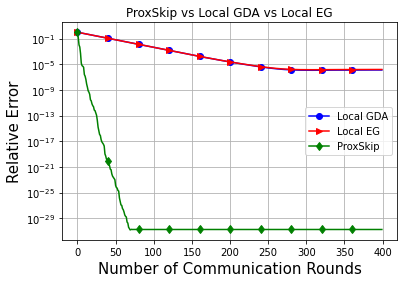

In [6]:
fig = plt.figure()

markers_on = np.arange(0, exp1_communication_round, exp1_communication_round/10).astype(int).tolist()
plt.plot(np.arange(exp1_communication_round), exp1_tuned_local_SGDA_error,'-bo', markevery = markers_on, label = 'Local GDA')
plt.plot(np.arange(exp1_communication_round), exp1_tuned_local_SEG_error,'-r>', markevery = markers_on, label = 'Local EG')
plt.plot(np.arange(exp1_communication_round), exp1_tuned_ProxSkip_VIP_FL_error, '-gd', markevery = markers_on, label = 'ProxSkip')


plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error", fontsize = 15)
plt.xlabel("Number of Communication Rounds", fontsize = 15)
plt.legend(fontsize = 10)
plt.title("ProxSkip vs Local GDA vs Local EG")

plt.savefig('Plots/ProxSkip vs Local GDA vs Local_EG with tuned stepsize on Hetergeneous Data.pdf', bbox_inches='tight')


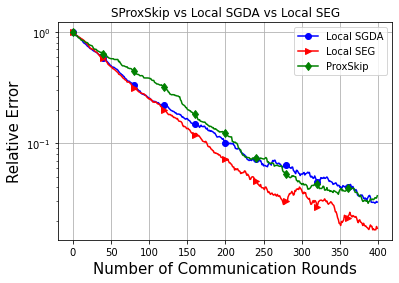

In [7]:
fig = plt.figure()

markers_on = np.arange(0, exp1_communication_round, exp1_communication_round/10).astype(int).tolist()
plt.plot(np.arange(exp1_communication_round), exp1_stoch_tuned_local_SGDA_error,'-bo', markevery = markers_on, label = 'Local SGDA')
plt.plot(np.arange(exp1_communication_round), exp1_stoch_tuned_local_SEG_error,'-r>', markevery = markers_on, label = 'Local SEG')
plt.plot(np.arange(exp1_communication_round), exp1_stoch_tuned_ProxSkip_VIP_FL_error, '-gd', markevery = markers_on, label = 'ProxSkip')


plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error", fontsize = 15)
plt.xlabel("Number of Communication Rounds", fontsize = 15)
plt.legend(fontsize = 10)
plt.title("SProxSkip vs Local SGDA vs Local SEG")

plt.savefig('Plots/SProxSkip vs Local SGDA vs Local_SEG with tuned stepsize on Hetergeneous Data.pdf', bbox_inches='tight')
